In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import xgboost as xgb
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [85]:
data = pd.read_csv('combined_df.csv')
data.head()

,apr,nPaidOff,hasCF,isFraud,payFreq__B,payFreq__I,payFreq__M,payFreq__S,payFreq__W,fraud_rate_of_state,...,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat,clearfraudscore,past_loan_count,loanAmount_log,scheduledPayment_log,leadCost_log,past_paid_off_loan_amount_log
0,645.0,0.0,1,0,1,0,0,0,0,0.745763,...,0,0,0,0,736.0,0,6.216606,7.455599,2.397895,0.0
1,360.0,0.0,1,0,0,0,0,0,1,0.449559,...,0,0,0,0,545.0,0,5.707110,6.509499,1.386294,0.0
2,601.0,0.0,1,1,0,0,0,0,1,0.641944,...,0,0,0,0,710.0,0,6.398595,7.512776,1.945910,0.0
3,590.0,1.0,1,0,0,0,0,1,0,0.521505,...,0,0,1,0,872.0,0,6.398595,7.438589,0.000000,0.0
4,645.0,0.0,1,1,1,0,0,0,0,0.521505,...,0,0,0,0,782.0,0,6.398595,7.580292,1.945910,0.0


In [86]:
data['isFraud'].value_counts()

,count
isFraud,
1,17383
0,12135


In [87]:
data.shape

(29518, 26)

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29518 entries, 0 to 29517
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   apr                            29518 non-null  float64
 1   nPaidOff                       29518 non-null  float64
 2   hasCF                          29518 non-null  int64  
 3   isFraud                        29518 non-null  int64  
 4   payFreq__B                     29518 non-null  int64  
 5   payFreq__I                     29518 non-null  int64  
 6   payFreq__M                     29518 non-null  int64  
 7   payFreq__S                     29518 non-null  int64  
 8   payFreq__W                     29518 non-null  int64  
 9   fraud_rate_of_state            29518 non-null  float64
 10  leadType_bvMandatory           29518 non-null  int64  
 11  leadType_california            29518 non-null  int64  
 12  leadType_express               29518 non-null 

In [89]:
X = data.drop(columns=['isFraud'])
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Evaluation function

In [90]:

def evaluate_model(model_prob, model_pred, y_test):
  auc = roc_auc_score(y_test, model_prob)
  accuracy = accuracy_score(y_test, model_pred)
  classification_rep = classification_report(y_test, model_pred)
  confusion_mat = confusion_matrix(y_test, model_pred)

  print("AUC Score:", auc)
  print("Accuracy:", accuracy)
  print("Classification Report:\n", classification_rep)
  print("Confusion Matrix:\n", confusion_mat)

  return auc

# Data modelling
- This part will build the baseline model for comparison, fine-tuning for the best model in this part. Reduce the time in fine-tuning for each models.
- 5 models will to be used to perform data modelling:
  - Random Forest
  - Logistic Regerssion
  - Support Vector Machine
  - XGBoost
  - Nueral Network

##**Random Forest**

In [91]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

y_prob = rfc.predict_proba(X_test)[:, 1]
y_pred = y_prob >= 0.5

rf_auc = evaluate_model(y_prob, y_pred, y_test)

AUC Score: 0.7020680550933656
Accuracy: 0.6636178861788617
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.53      0.56      3657
           1       0.70      0.76      0.73      5199

    accuracy                           0.66      8856
   macro avg       0.65      0.64      0.65      8856
weighted avg       0.66      0.66      0.66      8856

Confusion Matrix:
 [[1925 1732]
 [1247 3952]]


## Logistic Regression

**scale festures fro logistic regression and svm**

In [92]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [93]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)

y_prob = lr.predict_proba(X_test_scaled)[:,1]
y_pred = y_prob >= 0.5

lr_auc = evaluate_model(y_prob, y_pred, y_test)

AUC Score: 0.7231112049429165
Accuracy: 0.6761517615176151
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.46      0.54      3657
           1       0.68      0.83      0.75      5199

    accuracy                           0.68      8856
   macro avg       0.67      0.64      0.64      8856
weighted avg       0.67      0.68      0.66      8856

Confusion Matrix:
 [[1666 1991]
 [ 877 4322]]


## Support Vector Machine

In [94]:
model = svm.SVC(probability=True, random_state=42)
model.fit(X_train_scaled, y_train)

y_prob = model.predict_proba(X_test_scaled)[:,1]
y_pred = y_prob >= 0.5
svm_auc = evaluate_model(y_prob, y_pred, y_test)


AUC Score: 0.7229597275890176
Accuracy: 0.6726513098464318
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.43      0.52      3657
           1       0.68      0.84      0.75      5199

    accuracy                           0.67      8856
   macro avg       0.67      0.64      0.64      8856
weighted avg       0.67      0.67      0.66      8856

Confusion Matrix:
 [[1583 2074]
 [ 825 4374]]


## XGBoost

In [95]:

model = xgb.XGBClassifier()

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
y_pred = y_prob >= 0.5

xgb_auc = evaluate_model(y_prob, y_pred, y_test)


AUC Score: 0.7264208273366973
Accuracy: 0.6801038843721771
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.50      0.56      3657
           1       0.70      0.81      0.75      5199

    accuracy                           0.68      8856
   macro avg       0.67      0.65      0.66      8856
weighted avg       0.68      0.68      0.67      8856

Confusion Matrix:
 [[1837 1820]
 [1013 4186]]


# Compare baseline performance using auc score

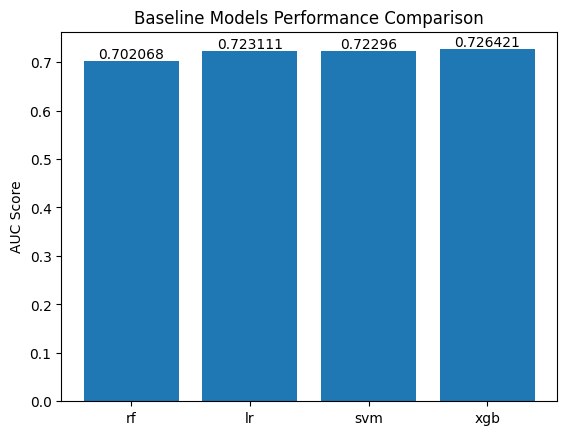

In [96]:

categories = ['rf', 'lr', 'svm', 'xgb']
values = [rf_auc, lr_auc, svm_auc, xgb_auc]
fig, ax = plt.subplots()
bars = ax.bar(categories, values)

ax.bar_label(bars)
ax.set_ylabel("AUC Score")
ax.set_title("Baseline Models Performance Comparison")
plt.show()


**XGBoost is the best baseline model with 0.655 AUC score, we fine-tune for only XGBoost**

In [97]:
important_features = pd.DataFrame({'importance':model.feature_importances_})
important_features['label'] = X.columns
important_features.sort_values(by='importance', ascending=False)

,importance,label
1,0.259459,nPaidOff
13,0.075820,leadType_lead
8,0.060266,fraud_rate_of_state
4,0.058641,payFreq__I
19,0.042983,clearfraudscore
10,0.042408,leadType_california
23,0.038699,leadCost_log
2,0.038357,hasCF
17,0.038342,leadType_rc_returning
22,0.037555,scheduledPayment_log


**drops not important features**

In [98]:
X_test_xgb = X_test.drop(columns=['leadType_instant-offer'])
X_train_xgb = X_train.drop(columns=['leadType_instant-offer'])

# Fine tuning best baseline model (XGB)

In [99]:

xgb_model = xgb.XGBClassifier()

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.5, 0.7, 0.8]
}


grid = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    verbose=0,
    n_jobs=1,
    random_state=42
)

grid.fit(X_train_xgb, y_train)
print("Best parameters:", grid.best_params_)
print("Best CV auc score:", grid.best_score_)


Best parameters: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.5}
Best CV auc score: 0.7261520569669591


In [100]:
best_xgb = grid.best_estimator_
best_xgb.fit(X_train_xgb, y_train)

y_prob = best_xgb.predict_proba(X_test_xgb)[:, 1]
y_pred = y_prob >= 0.5

best_xgb_auc = evaluate_model(y_prob, y_pred, y_test)

AUC Score: 0.7421202979496436
Accuracy: 0.6875564588979223
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.50      0.57      3657
           1       0.70      0.82      0.75      5199

    accuracy                           0.69      8856
   macro avg       0.68      0.66      0.66      8856
weighted avg       0.68      0.69      0.68      8856

Confusion Matrix:
 [[1827 1830]
 [ 937 4262]]


# Nueral Network

In [101]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [102]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [103]:
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)

X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [104]:
X_train_torch.shape, y_train_torch.shape

(torch.Size([20662, 25]), torch.Size([20662, 1]))

In [105]:

train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch),
                          batch_size=64, shuffle=True)

In [106]:
class model(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_dim, 64),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(32, 16),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(16, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x)

torch.manual_seed(42)
model = model(input_dim=X_train.shape[1]).to(device)

In [107]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [108]:
epochs = 100
patient = 10
min_loss = 999

for epoch in range(epochs):
  model.train()
  epoch_loss = 0
  for X_batch, y_batch in train_loader:
    y_pred = model(X_batch)
    loss = loss_fn(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  model.eval()
  with torch.inference_mode():
    y_pred = model(X_test_torch)
    loss_test = loss_fn(y_pred, y_test_torch)
    print(f" epoch {epoch} : loss {loss_test}")
    if loss_test < min_loss:
      min_loss = loss_test
      patience = 10
    else:
      patience -= 1
    if patience == 0: break

 epoch 0 : loss 0.6089802384376526
 epoch 1 : loss 0.6064607501029968
 epoch 2 : loss 0.6019579172134399
 epoch 3 : loss 0.6002331972122192
 epoch 4 : loss 0.6013078689575195
 epoch 5 : loss 0.598483145236969
 epoch 6 : loss 0.5969323515892029
 epoch 7 : loss 0.5955608487129211
 epoch 8 : loss 0.5955923199653625
 epoch 9 : loss 0.5957346558570862
 epoch 10 : loss 0.5947916507720947
 epoch 11 : loss 0.5955763459205627
 epoch 12 : loss 0.5947434306144714
 epoch 13 : loss 0.5950631499290466
 epoch 14 : loss 0.5981382131576538
 epoch 15 : loss 0.5946587324142456
 epoch 16 : loss 0.5928977727890015
 epoch 17 : loss 0.595122754573822
 epoch 18 : loss 0.5942533016204834
 epoch 19 : loss 0.5941674709320068
 epoch 20 : loss 0.5932146310806274
 epoch 21 : loss 0.5929857492446899
 epoch 22 : loss 0.5922482013702393
 epoch 23 : loss 0.5943173766136169
 epoch 24 : loss 0.5932265520095825
 epoch 25 : loss 0.5936688780784607
 epoch 26 : loss 0.5942636132240295
 epoch 27 : loss 0.591322660446167
 epoc

In [109]:
prod = model(X_test_torch).detach().cpu().numpy()
y_pred = prod >= 0.5
nn_auc = evaluate_model(prod, y_pred, y_test)

AUC Score: 0.7366979346430971
Accuracy: 0.6830397470641373
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.46      0.55      3657
           1       0.69      0.84      0.76      5199

    accuracy                           0.68      8856
   macro avg       0.68      0.65      0.65      8856
weighted avg       0.68      0.68      0.67      8856

Confusion Matrix:
 [[1688 1969]
 [ 838 4361]]


# Fine-tuned XGBoost vs Nuaral Network

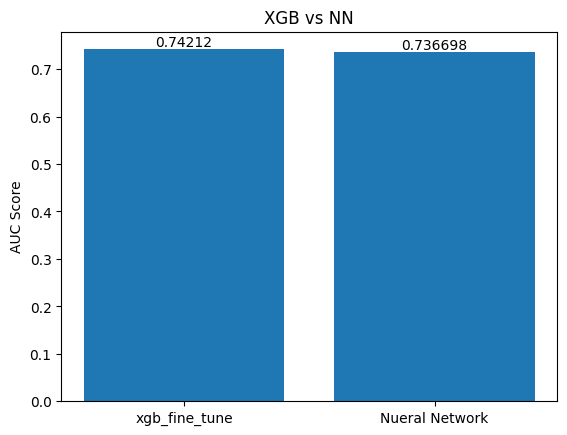

In [110]:
categories = ['xgb_fine_tune', 'Nueral Network']
values = [best_xgb_auc, nn_auc]
fig, ax = plt.subplots()
bars = ax.bar(categories, values)

ax.bar_label(bars)
ax.set_ylabel("AUC Score")
ax.set_title("XGB vs NN")
plt.show()

**XGBoost still the best model**

# Select the best classification thereshold for best model
- Formula: True Posistive Rate (tpr) - False Positive Rate (fpr)
- result: Maximize the true fraud alarms(TP) while minimize the false fraud alarms(FP).
- reasons: suitable for fraud detection, which can catch the most fraud loans as posible, while avoid too many of false fraud alarms.  
- But this is not alway best choise, this way is to balanced the FN and FP.
- To reduce the FN or FP is depends of the business priorities.
- If the business is plan to reduce the financial loss from fraud, then choose to reduce FN. But notice, loss of a good customer will also a financial loss.

In [111]:
y_prob = best_xgb.predict_proba(X_test_xgb)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
best_thresh = thresholds[(tpr - fpr).argmax()]
print("Optimal Threshold:", best_thresh)

Optimal Threshold: 0.614533


**0.6145 is the best thereshold for fine-tuned XGBoost.**

In [112]:
y_pred = y_prob >= best_thresh
best_xgb_auc = evaluate_model(y_prob, y_pred, y_test)

AUC Score: 0.7421202979496436
Accuracy: 0.6754742547425474
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.71      0.64      3657
           1       0.76      0.65      0.70      5199

    accuracy                           0.68      8856
   macro avg       0.67      0.68      0.67      8856
weighted avg       0.69      0.68      0.68      8856

Confusion Matrix:
 [[2588 1069]
 [1805 3394]]


In [113]:
import pickle

with open("best_xgb_model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)

# Result:
- the best model is XGBoost with 0.7421 AUC score, 0.65 recall, and 0.76 presicion of fraud class.
- 0.7421 AUC score indicates when there have 1 fraud and 1 non-fraud loan sample, this model will ranks the fraud risk for the fraud sample higher than another in 74.21 percents of time.
- 0.76 precision of class 1 means all model predicted fraud, 76% of them is actually fraud.
- 0.65 recall of class 1 means all actual fraud loans, the model successfully detect 65% of them as fraud.